In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/10-monkey-species/monkey_labels.txt
/kaggle/input/10-monkey-species/validation/validation/n7/n711.jpg
/kaggle/input/10-monkey-species/validation/validation/n7/n703.jpg
/kaggle/input/10-monkey-species/validation/validation/n7/n7015.jpg
/kaggle/input/10-monkey-species/validation/validation/n7/n7017.jpg
/kaggle/input/10-monkey-species/validation/validation/n7/n709.jpg
/kaggle/input/10-monkey-species/validation/validation/n7/n712.jpg
/kaggle/input/10-monkey-species/validation/validation/n7/n710.jpg
/kaggle/input/10-monkey-species/validation/validation/n7/n7012.jpg
/kaggle/input/10-monkey-species/validation/validation/n7/n713.jpg
/kaggle/input/10-monkey-species/validation/validation/n7/n7011.jpg
/kaggle/input/10-monkey-species/validation/validation/n7/n7016.jpg
/kaggle/input/10-monkey-species/validation/validation/n7/n7010.jpg
/kaggle/input/10-monkey-species/validation/validation/n7/n706.jpg
/kaggle/input/10-monkey-species/validation/validation/n7/n717.jpg
/kaggle/input/10-mon

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import pandas as pd
import os, sys, time

import tensorflow as tf
from tensorflow import keras

%matplotlib inline

print(tf.__version__)
print(sys.version_info)

2.1.0
sys.version_info(major=3, minor=6, micro=6, releaselevel='final', serial=0)


In [3]:
train_dir = "/kaggle/input/10-monkey-species/training/training/"
valid_dir = "/kaggle/input/10-monkey-species/validation/validation/"
label_dir = "/kaggle/input/10-monkey-species/monkey_labels.txt"
print(os.path.exists(train_dir))
print(os.path.exists(valid_dir))
print(os.path.exists(valid_dir))

True
True
True


In [4]:
labels = pd.read_csv(label_dir, header=0)
print(labels)

   Label     Latin Name              Common Name                     \
0  n0         alouatta_palliata\t    mantled_howler                   
1  n1        erythrocebus_patas\t    patas_monkey                     
2  n2        cacajao_calvus\t        bald_uakari                      
3  n3        macaca_fuscata\t        japanese_macaque                 
4  n4       cebuella_pygmea\t        pygmy_marmoset                   
5  n5       cebus_capucinus\t        white_headed_capuchin            
6  n6       mico_argentatus\t        silvery_marmoset                 
7  n7      saimiri_sciureus\t        common_squirrel_monkey           
8  n8       aotus_nigriceps\t        black_headed_night_monkey        
9  n9       trachypithecus_johnii    nilgiri_langur                   

    Train Images    Validation Images  
0             131                  26  
1             139                  28  
2             137                  27  
3             152                  30  
4             131 

In [5]:
height = 128
width = 128
channels = 3
batch_size = 64
num_classes = 10

train_data = keras.preprocessing.image.ImageDataGenerator(
    rescale=1. / 255.,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
)
train_generator = train_data.flow_from_directory(
    train_dir,
    target_size=(height, width),
    batch_size=batch_size,
    shuffle=True,
    class_mode='categorical',
    seed=7
)
valid_data = keras.preprocessing.image.ImageDataGenerator(
    rescale=1. / 255.,
)
valid_generator = valid_data.flow_from_directory(
    valid_dir,
    target_size=(height, width),
    batch_size=batch_size,
    shuffle=False,
    class_mode='categorical',
    seed=7
)

print(train_generator.samples,
      valid_generator.samples)

Found 1098 images belonging to 10 classes.
Found 272 images belonging to 10 classes.
1098 272


In [6]:
model = keras.Sequential([
    keras.layers.Conv2D(filters=32, kernel_size=3, padding='same',
                        activation='relu', input_shape=[width, height, channels]),
    keras.layers.Conv2D(filters=32, kernel_size=3, padding='same',
                        activation='relu'),
    keras.layers.MaxPooling2D(pool_size=2),

    keras.layers.Conv2D(filters=64, kernel_size=3, padding='same',
                        activation='relu'),
    keras.layers.Conv2D(filters=64, kernel_size=3, padding='same',
                        activation='relu'),
    keras.layers.MaxPooling2D(pool_size=2),

    keras.layers.Conv2D(filters=128, kernel_size=3, padding='same',
                        activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=3, padding='same',
                        activation='relu'),
    keras.layers.MaxPooling2D(pool_size=2),

    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='selu'),
    keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 128)       7

In [11]:
epochs = 10
history = model.fit_generator(train_generator,
                              steps_per_epoch=1098 // batch_size,
                              epochs=epochs,
                              validation_data=valid_generator,
                              validation_steps=272 // batch_size)

Train for 17 steps, validate for 4 steps
Epoch 1/10
17/17 [==============================] - 37s 2s/step - loss: 1.8781 - accuracy: 0.2969 - val_loss: 1.7073 - val_accuracy: 0.4297
Epoch 2/10
17/17 [==============================] - 37s 2s/step - loss: 1.7601 - accuracy: 0.3665 - val_loss: 1.4902 - val_accuracy: 0.4727
Epoch 3/10
17/17 [==============================] - 37s 2s/step - loss: 1.7394 - accuracy: 0.3704 - val_loss: 1.5152 - val_accuracy: 0.4609
Epoch 4/10
17/17 [==============================] - 37s 2s/step - loss: 1.5090 - accuracy: 0.4449 - val_loss: 1.5278 - val_accuracy: 0.4648
Epoch 5/10
17/17 [==============================] - 37s 2s/step - loss: 1.4966 - accuracy: 0.4758 - val_loss: 1.3855 - val_accuracy: 0.4922
Epoch 6/10
17/17 [==============================] - 38s 2s/step - loss: 1.4155 - accuracy: 0.4778 - val_loss: 1.2824 - val_accuracy: 0.5391
Epoch 7/10
17/17 [==============================] - 38s 2s/step - loss: 1.3243 - accuracy: 0.4990 - val_loss: 1.2928 - 

In [13]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [ ]:
def plot_learning_curve(history, label, epochs, min_val, max_val):
    data = {}
    data[label] = history.history[label]
    data['val_' + label] = history.history['val_' + label]

    pd.DataFrame(data).plot(figsize=(8, 5))
    plt.grid(True)
    plt.axis([0, epochs, min_val, max_val])
    # plt.gca().set_ylim(0, 1)
    plt.show()

plot_learning_curve(history, 'accuracy', epochs, 0, 1)
plot_learning_curve(history, 'loss', epochs, 0, 2)

#### READ from CSV

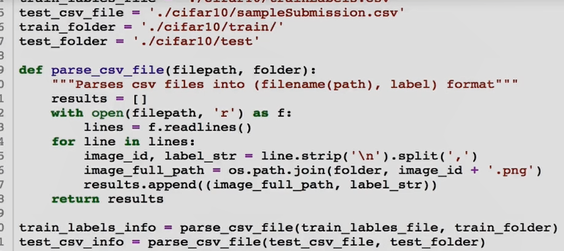

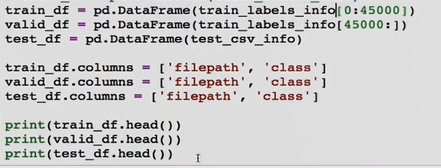

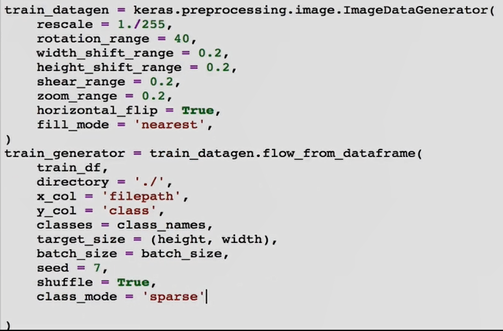

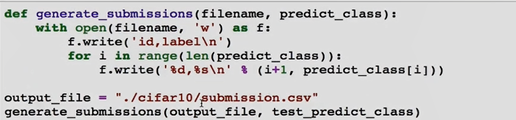